In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display, clear_output
from warnings import filterwarnings

# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Ajustar la ruta al directorio en Google Drive
data_path = '/content/drive/My Drive/Colab Notebooks/archive'

# Listar archivos en el directorio
for dirname, _, filenames in os.walk(data_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Se truncaron las últimas líneas 5000 del resultado de transmisión.
/content/drive/My Drive/Colab Notebooks/archive/Dataset2/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_22.tif
/content/drive/My Drive/Colab Notebooks/archive/Dataset2/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_23.tif
/content/drive/My Drive/Colab Notebooks/archive/Dataset2/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_20_mask.tif
/content/drive/My Drive/Colab Notebooks/archive/Dataset2/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_2_mask.tif
/content/drive/My Drive/Colab Notebooks/archive/Dataset2/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_22_mask.tif
/content/drive/My Drive/Colab Notebooks/archive/Dataset2/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_2.tif
/content/drive/My Drive/Colab Notebooks/archive/Dataset2/lgg-mri-segmentation/kaggle_3

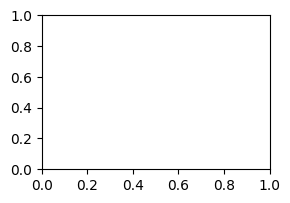

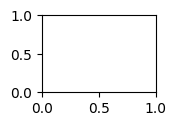

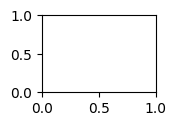

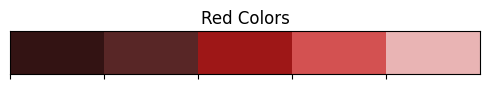

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definir las paletas de colores
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C', '#4B6F44', '#4F7942', '#74C365', '#D0F0C0']

# Visualizar las paletas de colores
plt.figure(figsize=(10, 2))

plt.subplot(1, 3, 1)
sns.palplot(colors_dark)
plt.title('Dark Colors')

plt.subplot(1, 3, 2)
sns.palplot(colors_green)
plt.title('Green Colors')

plt.subplot(1, 3, 3)
sns.palplot(colors_red)
plt.title('Red Colors')

plt.tight_layout()
plt.show()

In [4]:
import numpy as np
import cv2
from tqdm import tqdm

# Definir las etiquetas de las clases
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']

# Definir el tamaño de la imagen
image_size = 150

# Crear listas para almacenar las imágenes y las etiquetas
X_train = []
y_train = []

# Ruta a la carpeta de datos en Google Drive
data_path = '/content/drive/My Drive/Colab Notebooks/archive'

# Cargar imágenes de la carpeta de entrenamiento
for i in labels:
    folderPath = os.path.join(data_path, 'Training', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        y_train.append(i)

# Cargar imágenes de la carpeta de prueba
for i in labels:
    folderPath = os.path.join(data_path, 'Testing', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        y_train.append(i)

# Convertir las listas a arrays de numpy
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:24<00:00,  3.05it/s]


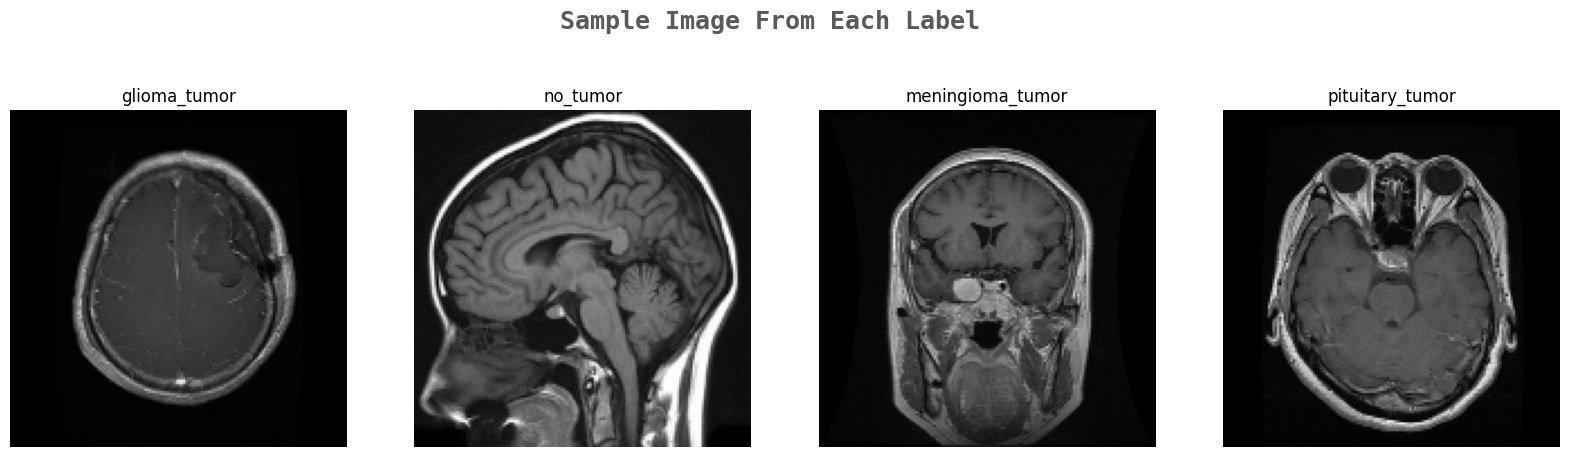

In [5]:
import matplotlib.pyplot as plt

# Definir la figura y los ejes para mostrar imágenes
k = 0
fig, ax = plt.subplots(1, 4, figsize=(20, 20))
fig.text(s='Sample Image From Each Label', size=18, fontweight='bold',
         fontname='monospace', color=colors_dark[1], y=0.62, x=0.4, alpha=0.8)

# Mostrar una imagen de muestra para cada etiqueta
for i in labels:
    j = 0
    while True:
        if y_train[j] == i:
            ax[k].imshow(cv2.cvtColor(X_train[j], cv2.COLOR_BGR2RGB))  # Convertir BGR a RGB para visualizar correctamente
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k += 1
            break
        j += 1

plt.show()

In [6]:
from sklearn.utils import shuffle

# Mezclar las imágenes y las etiquetas aleatoriamente
X_train, y_train = shuffle(X_train, y_train, random_state=101)

# Imprimir la forma del array de imágenes de entrenamiento
X_train.shape

(3264, 150, 150, 3)

In [7]:
from sklearn.model_selection import train_test_split

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=101)

# Mostrar las etiquetas del conjunto de entrenamiento
y_train

array(['glioma_tumor', 'no_tumor', 'no_tumor', ..., 'meningioma_tumor',
       'pituitary_tumor', 'meningioma_tumor'], dtype='<U16')

In [8]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [9]:
from tensorflow.keras.applications import EfficientNetB0

# Cargar el modelo EfficientNetB0 preentrenado sin las capas superiores
effnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
import tensorflow as tf

# Definir la parte superior del modelo
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4, activation='softmax')(model)

# Crear el modelo final
model = tf.keras.models.Model(inputs=effnet.input, outputs=model)

In [11]:
# Mostrar un resumen de la arquitectura del modelo
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 150, 150, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 150, 150, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 150, 150, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 151, 151, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 75, 75, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 75, 75, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 75, 75, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 75, 75, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 75, 75, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 75, 75, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 4,012,672 (15.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [12]:
# Compilar el modelo
model.compile(
    loss='categorical_crossentropy',    # Función de pérdida para clasificación multiclase
    optimizer='Adam',                   # Optimizador Adam
    metrics=['accuracy']                # Métrica para evaluar el rendimiento del modelo
)

In [13]:
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

# Configurar TensorBoard para visualizar el entrenamiento
tensorboard = TensorBoard(log_dir='logs')

# Guardar el mejor modelo basado en la precisión de validación
checkpoint = ModelCheckpoint(
    "effnet.keras",                   # Nombre del archivo para guardar el modelo en formato .keras
    monitor="val_accuracy",          # Métrica para monitorear
    save_best_only=True,              # Guardar solo el mejor modelo
    mode="auto",                     # Modo automático para determinar si la métrica está aumentando o disminuyendo
    verbose=1                        # Verbose para mostrar mensajes durante el entrenamiento
)

# Reducir la tasa de aprendizaje cuando la precisión de validación no mejora
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',          # Métrica para monitorear
    factor=0.3,                      # Factor para reducir la tasa de aprendizaje
    patience=2,                      # Número de épocas sin mejora antes de reducir la tasa de aprendizaje
    min_delta=0.001,                 # Cambio mínimo en la métrica para considerarla como mejora
    mode='auto',                    # Modo automático para determinar si la métrica está aumentando o disminuyendo
    verbose=1                        # Verbose para mostrar mensajes durante el entrenamiento
)

In [15]:
# Entrenar el modelo
history = model.fit(
    X_train,                           # Datos de entrenamiento
    y_train,                           # Etiquetas de entrenamiento
    validation_split=0.1,              # Porción de datos para validación
    epochs=24,                         # Número de épocas para el entrenamiento
    verbose=1,                         # Mostrar el progreso del entrenamiento
    batch_size=32,                     # Tamaño del lote
    callbacks=[tensorboard, checkpoint, reduce_lr]  # Callbacks para el entrenamiento
)

Epoch 1/24
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7680 - loss: 0.6354
Epoch 1: val_accuracy improved from -inf to 0.71429, saving model to effnet.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 407s 4s/step - accuracy: 0.7689 - loss: 0.6333 - val_accuracy: 0.7143 - val_loss: 0.8943 - learning_rate: 0.0010
Epoch 2/24
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9451 - loss: 0.1767
Epoch 2: val_accuracy improved from 0.71429 to 0.81293, saving model to effnet.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 376s 4s/step - accuracy: 0.9451 - loss: 0.1766 - val_accuracy: 0.8129 - val_loss: 0.7647 - learning_rate: 0.0010
Epoch 3/24
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9710 - loss: 0.1015
Epoch 3: val_accuracy improved from 0.81293 to 0.83673, saving model to effnet.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 380s 4s/step - accuracy: 0.9709 - loss: 0.1017 - val_accuracy: 0.8367 - val_loss: 0.6122 - learning_rate: 0.0010
Epoch 4/24
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9691 - loss: 0.1

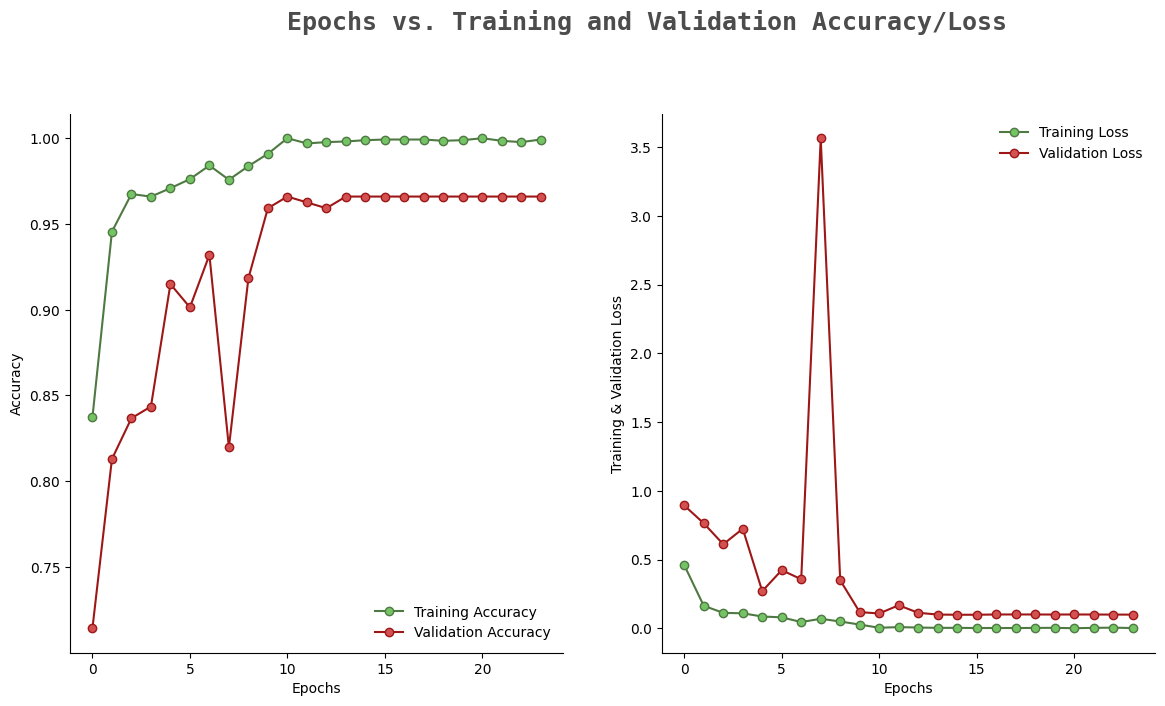

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from warnings import filterwarnings

# Ignorar advertencias
filterwarnings('ignore')

# Definir las épocas
epochs = [i for i in range(24)]

# Crear una figura con 2 subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# Obtener los datos de entrenamiento y validación desde el historial
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Agregar título a la figura
fig.text(s='Epochs vs. Training and Validation Accuracy/Loss', size=18, fontweight='bold',
         fontname='monospace', color='#1F1F1F', y=1, x=0.28, alpha=0.8)

# Configuración del primer subplot - Precisión
sns.despine()
ax[0].plot(epochs, train_acc, marker='o', markerfacecolor='#74C365', color='#4F7942',
           label='Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o', markerfacecolor='#D35151', color='#9E1717',
           label='Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

# Configuración del segundo subplot - Pérdida
sns.despine()
ax[1].plot(epochs, train_loss, marker='o', markerfacecolor='#74C365', color='#4F7942',
           label='Training Loss')
ax[1].plot(epochs, val_loss, marker='o', markerfacecolor='#D35151', color='#9E1717',
           label='Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

# Mostrar la figura
plt.show()

In [17]:
# Realizar predicciones en el conjunto de prueba
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)

# Convertir las etiquetas de prueba a su forma original
y_test_new = np.argmax(y_test, axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step


In [18]:
from sklearn.metrics import classification_report

# Imprimir el reporte de clasificación
print(classification_report(y_test_new, pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96        93
           1       1.00      0.98      0.99        51
           2       0.97      0.95      0.96        96
           3       0.98      1.00      0.99        87

    accuracy                           0.97       327
   macro avg       0.98      0.97      0.97       327
weighted avg       0.97      0.97      0.97       327



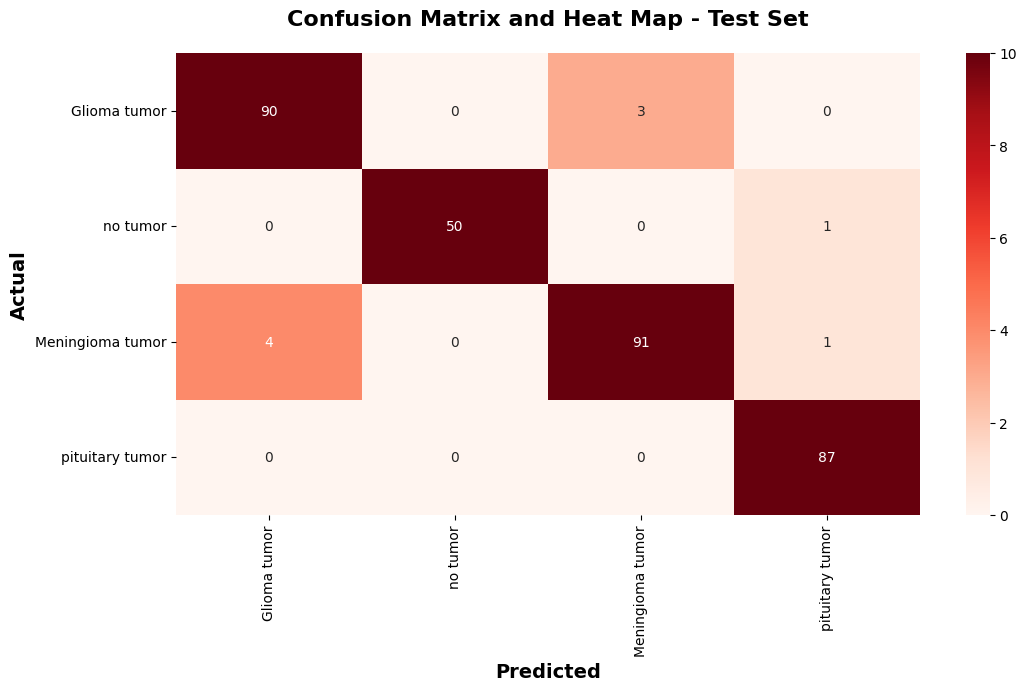

In [19]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Definir las categorías
categories = ['Glioma tumor', 'no tumor', 'Meningioma tumor', 'pituitary tumor']

# Crear la matriz de confusión
CMatrix = pd.DataFrame(confusion_matrix(y_test_new, pred), columns=categories, index=categories)

# Plotear la matriz de confusión
plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot=True, fmt='g', vmin=0, vmax=10, cmap='Reds')
ax.set_xlabel('Predicted', fontsize=14, weight='bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel('Actual', fontsize=14, weight='bold')
ax.set_title('Confusion Matrix and Heat Map - Test Set', fontsize=16, weight='bold', pad=20)
plt.show()